In [16]:
#
# Develop and compare multiple machine learning models to predict anemia based on blood test parameters
# Author @Jakub Chojdak
# github.com/jchojdak
#

In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [18]:
print("[#] Loading datasets...")

df_list = [
    # @/ https://www.kaggle.com/datasets/biswaranjanrao/anemia-dataset
    pd.read_csv("data/01-biswaranjanrao-anemia-dataset.csv"),
    # @/ https://www.kaggle.com/datasets/ragishehab/anemia-data-set
    pd.read_csv("data/02-ragishehab-anemia-dataset.csv")
]

# Combine datasets
dataset = pd.concat(df_list, ignore_index=True)
print(f"[#] Combined dataset shape: {dataset.shape}")

# Remove duplicates and handle missing values
initial_shape = dataset.shape
dataset = dataset.drop_duplicates()
dataset = dataset.dropna()

print(f"[#] After cleaning:")
print(f"- Removed {initial_shape[0] - dataset.shape[0]} duplicate/missing rows")
print(f"- Final dataset shape: {dataset.shape}")

[#] Loading datasets...
[#] Combined dataset shape: (9965, 6)
[#] After cleaning:
- Removed 932 duplicate/missing rows
- Final dataset shape: (9033, 6)


In [19]:
print("[#] DATASET OVERVIEW")
print("=" * 50)
print(f"Dataset dimensions: {dataset.shape}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024:.2f} KB")
print("\nColumn Information:")
print(dataset.info())

[#] DATASET OVERVIEW
Dataset dimensions: (9033, 6)
Memory usage: 493.99 KB

Column Information:
<class 'pandas.core.frame.DataFrame'>
Index: 9033 entries, 0 to 9964
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      9033 non-null   int64  
 1   Hemoglobin  9033 non-null   float64
 2   MCH         9033 non-null   float64
 3   MCHC        9033 non-null   float64
 4   MCV         9033 non-null   float64
 5   Result      9033 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 494.0 KB
None


In [20]:
print("[#] SAMPLE DATA")
print("=" * 30)
print("\n[#] First 5 rows:")
print(dataset.head())
print("\n[#] Last 5 rows:")
print(dataset.tail())

[#] SAMPLE DATA

[#] First 5 rows:
   Gender  Hemoglobin   MCH  MCHC   MCV  Result
0       1        14.9  22.7  29.1  83.7       0
1       0        15.9  25.4  28.3  72.0       0
2       0         9.0  21.5  29.6  71.2       1
3       0        14.9  16.0  31.4  87.5       0
4       1        14.7  22.0  28.2  99.5       0

[#] Last 5 rows:
      Gender  Hemoglobin   MCH  MCHC   MCV  Result
9960       0        12.7  27.8  33.3  83.6       0
9961       0        14.9  29.3  32.9  88.9       0
9962       1        12.2  28.9  35.0  82.7       1
9963       1        12.2  29.2  32.8  89.1       1
9964       0        13.7  27.2  33.7  80.7       0


In [21]:
print("[#] DESCRIPTIVE STATISTICS")
print("=" * 40)
print(dataset.describe().round(3))

[#] DESCRIPTIVE STATISTICS
         Gender  Hemoglobin       MCH      MCHC       MCV    Result
count  9033.000    9033.000  9033.000  9033.000  9033.000  9033.000
mean      0.509      13.659    29.051    33.598    86.934     0.347
std       0.500       1.533     3.076     1.354     6.710     0.476
min       0.000       6.400    16.000    27.800    55.700     0.000
25%       0.000      12.600    27.700    33.100    83.000     0.000
50%       1.000      13.600    29.500    33.800    87.400     0.000
75%       1.000      14.700    31.000    34.400    91.400     1.000
max       1.000      19.500    74.500    69.600   115.300     1.000


In [22]:
# Check for missing values
print("\n[#] Missing Values Check:")
missing_values = dataset.isnull().sum()
if missing_values.sum() == 0:
    print("[#] No missing values found!")
else:
    print(missing_values[missing_values > 0])


[#] Missing Values Check:
[#] No missing values found!


[#] TARGET VARIABLE ANALYSIS
Class Distribution:
   • No Anemia (Class 0): 5899 samples (65.3%)
   • Anemia (Class 1): 3134 samples (34.7%)


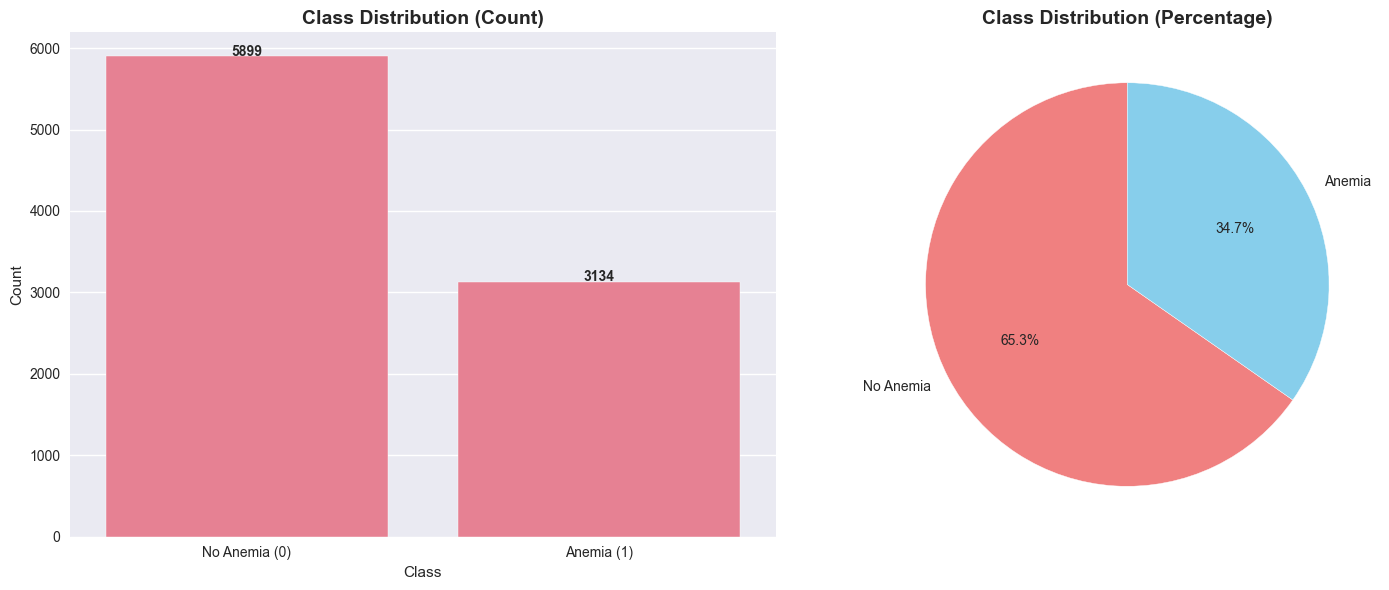

In [23]:
# Analyze target variable distribution
print("[#] TARGET VARIABLE ANALYSIS")
print("=" * 40)

target_counts = dataset['Result'].value_counts()
target_props = dataset['Result'].value_counts(normalize=True)

print("Class Distribution:")
for class_val, count in target_counts.items():
    prop = target_props[class_val]
    class_name = "No Anemia" if class_val == 0 else "Anemia"
    print(f"   • {class_name} (Class {class_val}): {count} samples ({prop:.1%})")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
sns.countplot(data=dataset, x='Result', ax=axes[0])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Anemia (0)', 'Anemia (1)'])

# Add count labels
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['lightcoral', 'skyblue']
axes[1].pie(target_counts.values, labels=['No Anemia', 'Anemia'],
           autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

[#] FEATURE ANALYSIS


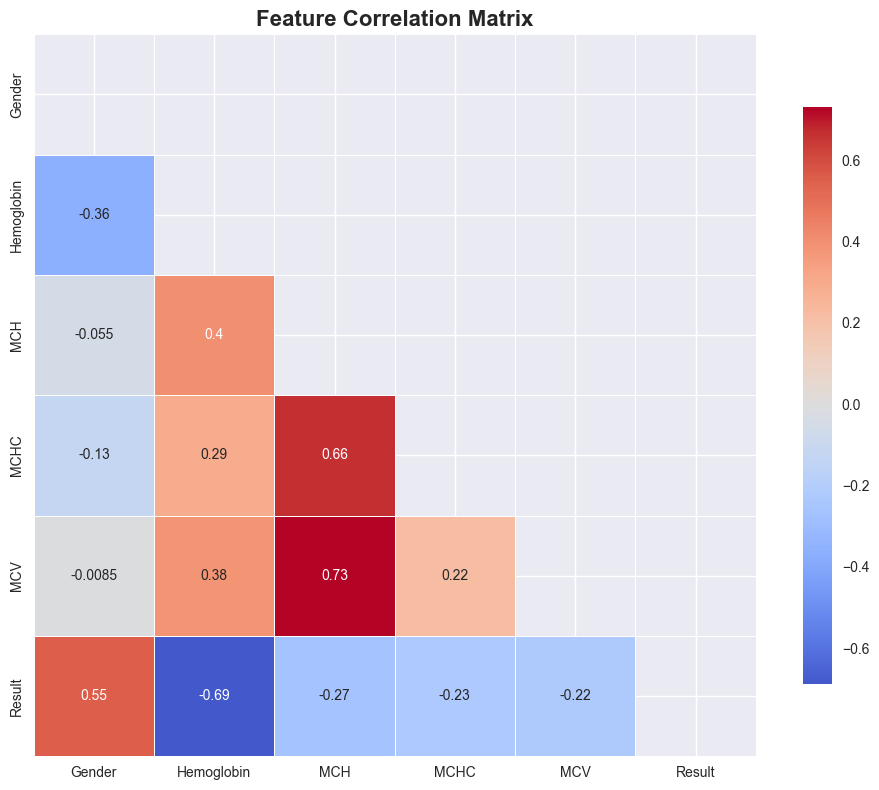

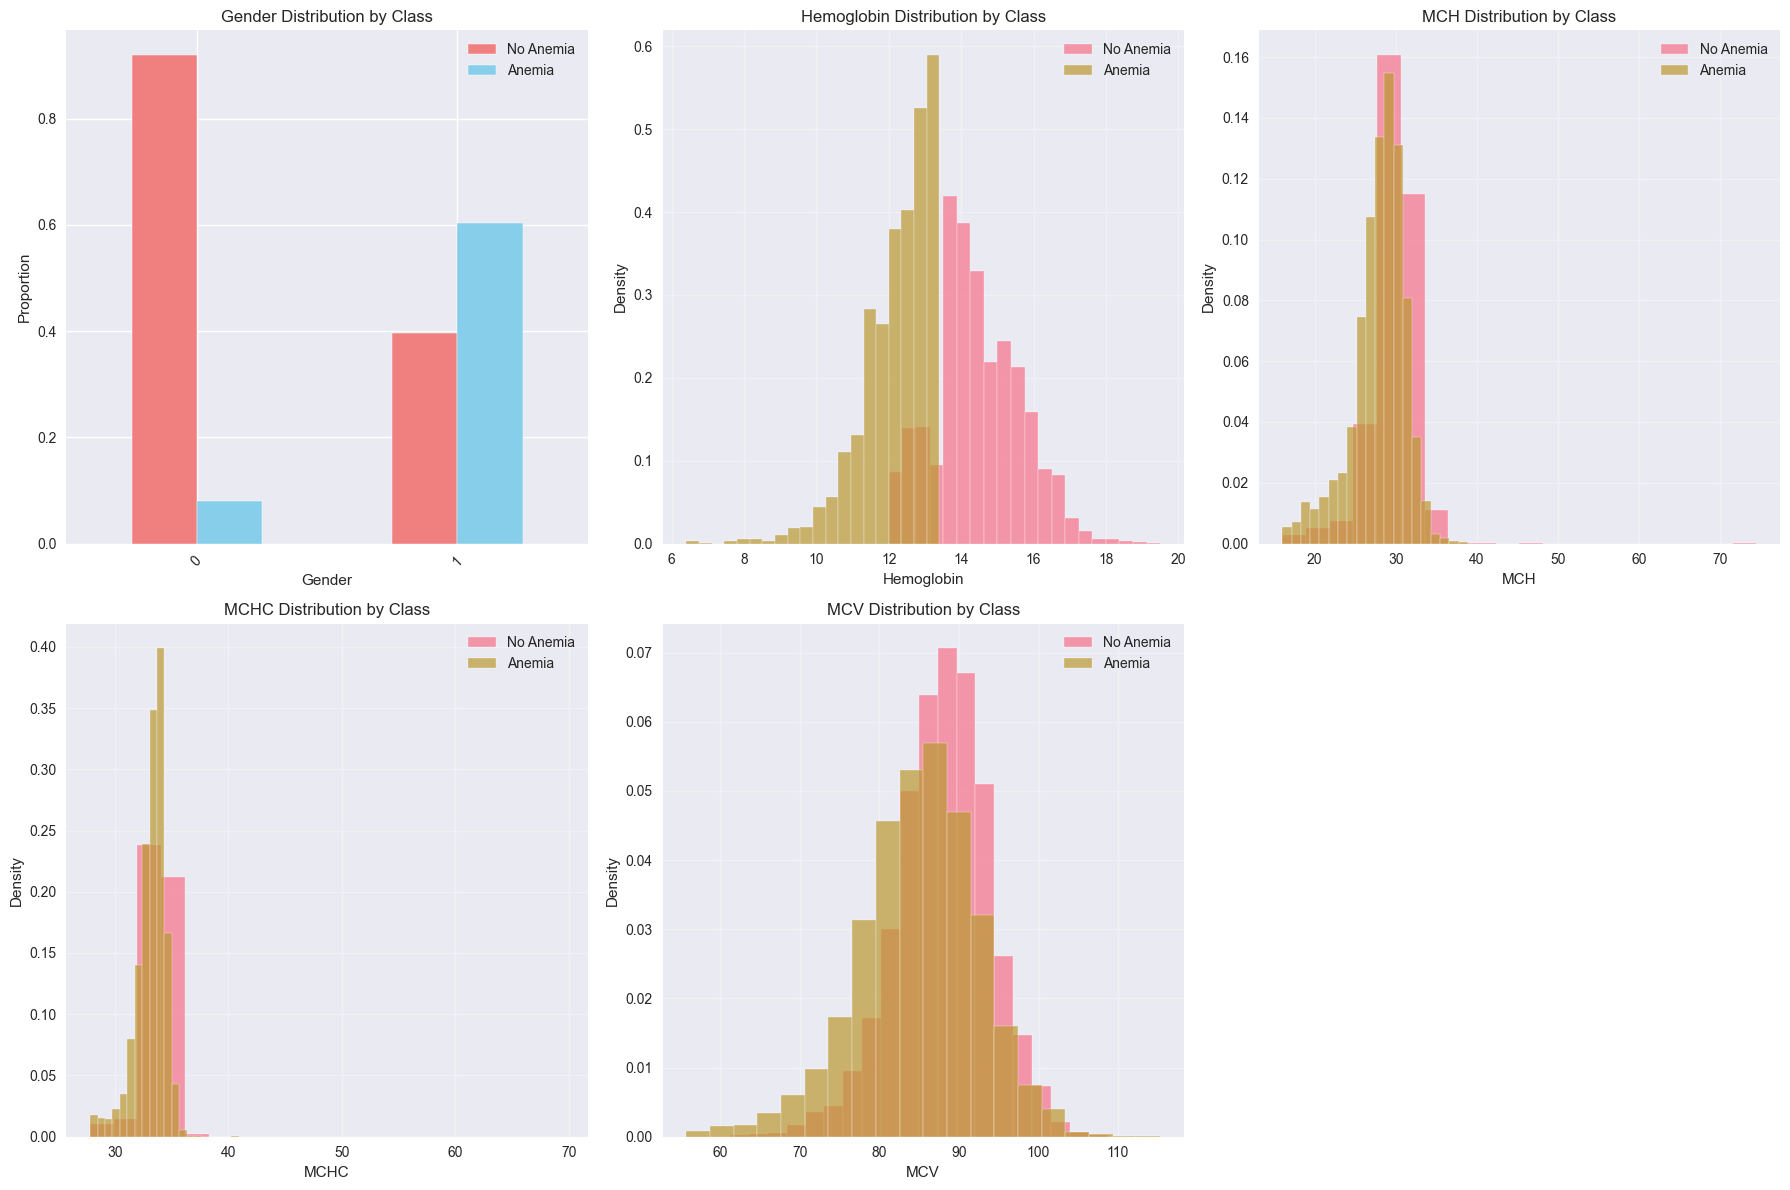

In [24]:
# Feature analysis and visualization
print("[#] FEATURE ANALYSIS")
print("=" * 30)

# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = dataset.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Distribution of features by class
features = ['Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(features):
    if feature == 'Gender':
        # For categorical feature
        crosstab = pd.crosstab(dataset[feature], dataset['Result'], normalize='index')
        crosstab.plot(kind='bar', ax=axes[i], color=['lightcoral', 'skyblue'])
        axes[i].set_title(f'{feature} Distribution by Class')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Proportion')
        axes[i].legend(['No Anemia', 'Anemia'])
        axes[i].tick_params(axis='x', rotation=45)
    else:
        # For numerical features
        for class_val in [0, 1]:
            class_name = "No Anemia" if class_val == 0 else "Anemia"
            data_subset = dataset[dataset['Result'] == class_val][feature]
            axes[i].hist(data_subset, alpha=0.7, bins=20,
                        label=class_name, density=True)

        axes[i].set_title(f'{feature} Distribution by Class')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Density')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

# Remove the empty subplot
axes[5].remove()

plt.tight_layout()
plt.show()

In [25]:
# Prepare data for modeling
print("[#] DATA PREPARATION FOR MODELING")
print("=" * 45)

# Separate features and target
X = dataset.drop(columns=['Result'])
y = dataset['Result']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n[#] Data split completed:")
print(f" - Training set: {X_train.shape[0]} samples")
print(f" - Test set: {X_test.shape[0]} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n[#] Feature scaling completed")
print(f" - Mean after scaling: ~{np.mean(X_train_scaled):.3f}")
print(f" - Std after scaling: ~{np.std(X_train_scaled):.3f}")

[#] DATA PREPARATION FOR MODELING
Features shape: (9033, 5)
Target shape: (9033,)
Feature columns: ['Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV']

[#] Data split completed:
 - Training set: 7226 samples
 - Test set: 1807 samples

[#] Feature scaling completed
 - Mean after scaling: ~-0.000
 - Std after scaling: ~1.000


In [26]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

print("[#] TRAINING MULTIPLE MODELS")
print("=" * 40)

# Train models and collect results
results = {}
model_objects = {}

for name, model in models.items():
    print(f"Training {name}...")

    # Train model
    if name in ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors']:
        # Models that benefit from scaling
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Don't require scaling
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'fpr': fpr,
        'tpr': tpr
    }

    model_objects[name] = model
    print(f"[#] {name} completed - Accuracy: {accuracy:.3f}")

print("\n[#] All models trained successfully!")

[#] TRAINING MULTIPLE MODELS
Training Logistic Regression...
[#] Logistic Regression completed - Accuracy: 1.000
Training Random Forest...
[#] Random Forest completed - Accuracy: 1.000
Training Gradient Boosting...
[#] Gradient Boosting completed - Accuracy: 1.000
Training Support Vector Machine...
[#] Support Vector Machine completed - Accuracy: 0.997
Training K-Nearest Neighbors...
[#] K-Nearest Neighbors completed - Accuracy: 0.983
Training Decision Tree...
[#] Decision Tree completed - Accuracy: 1.000
Training Naive Bayes...
[#] Naive Bayes completed - Accuracy: 0.935

[#] All models trained successfully!


[#] MODEL PERFORMANCE COMPARISON
Performance metrics summary:
                        Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression       1.0000     1.0000  1.0000    1.0000   1.0000
Random Forest             1.0000     1.0000  1.0000    1.0000   1.0000
Gradient Boosting         1.0000     1.0000  1.0000    1.0000   1.0000
Support Vector Machine    0.9972     0.9984  0.9936    0.9960   0.9999
K-Nearest Neighbors       0.9828     0.9869  0.9633    0.9750   0.9979
Decision Tree             1.0000     1.0000  1.0000    1.0000   1.0000
Naive Bayes               0.9347     0.9263  0.8820    0.9036   0.9817


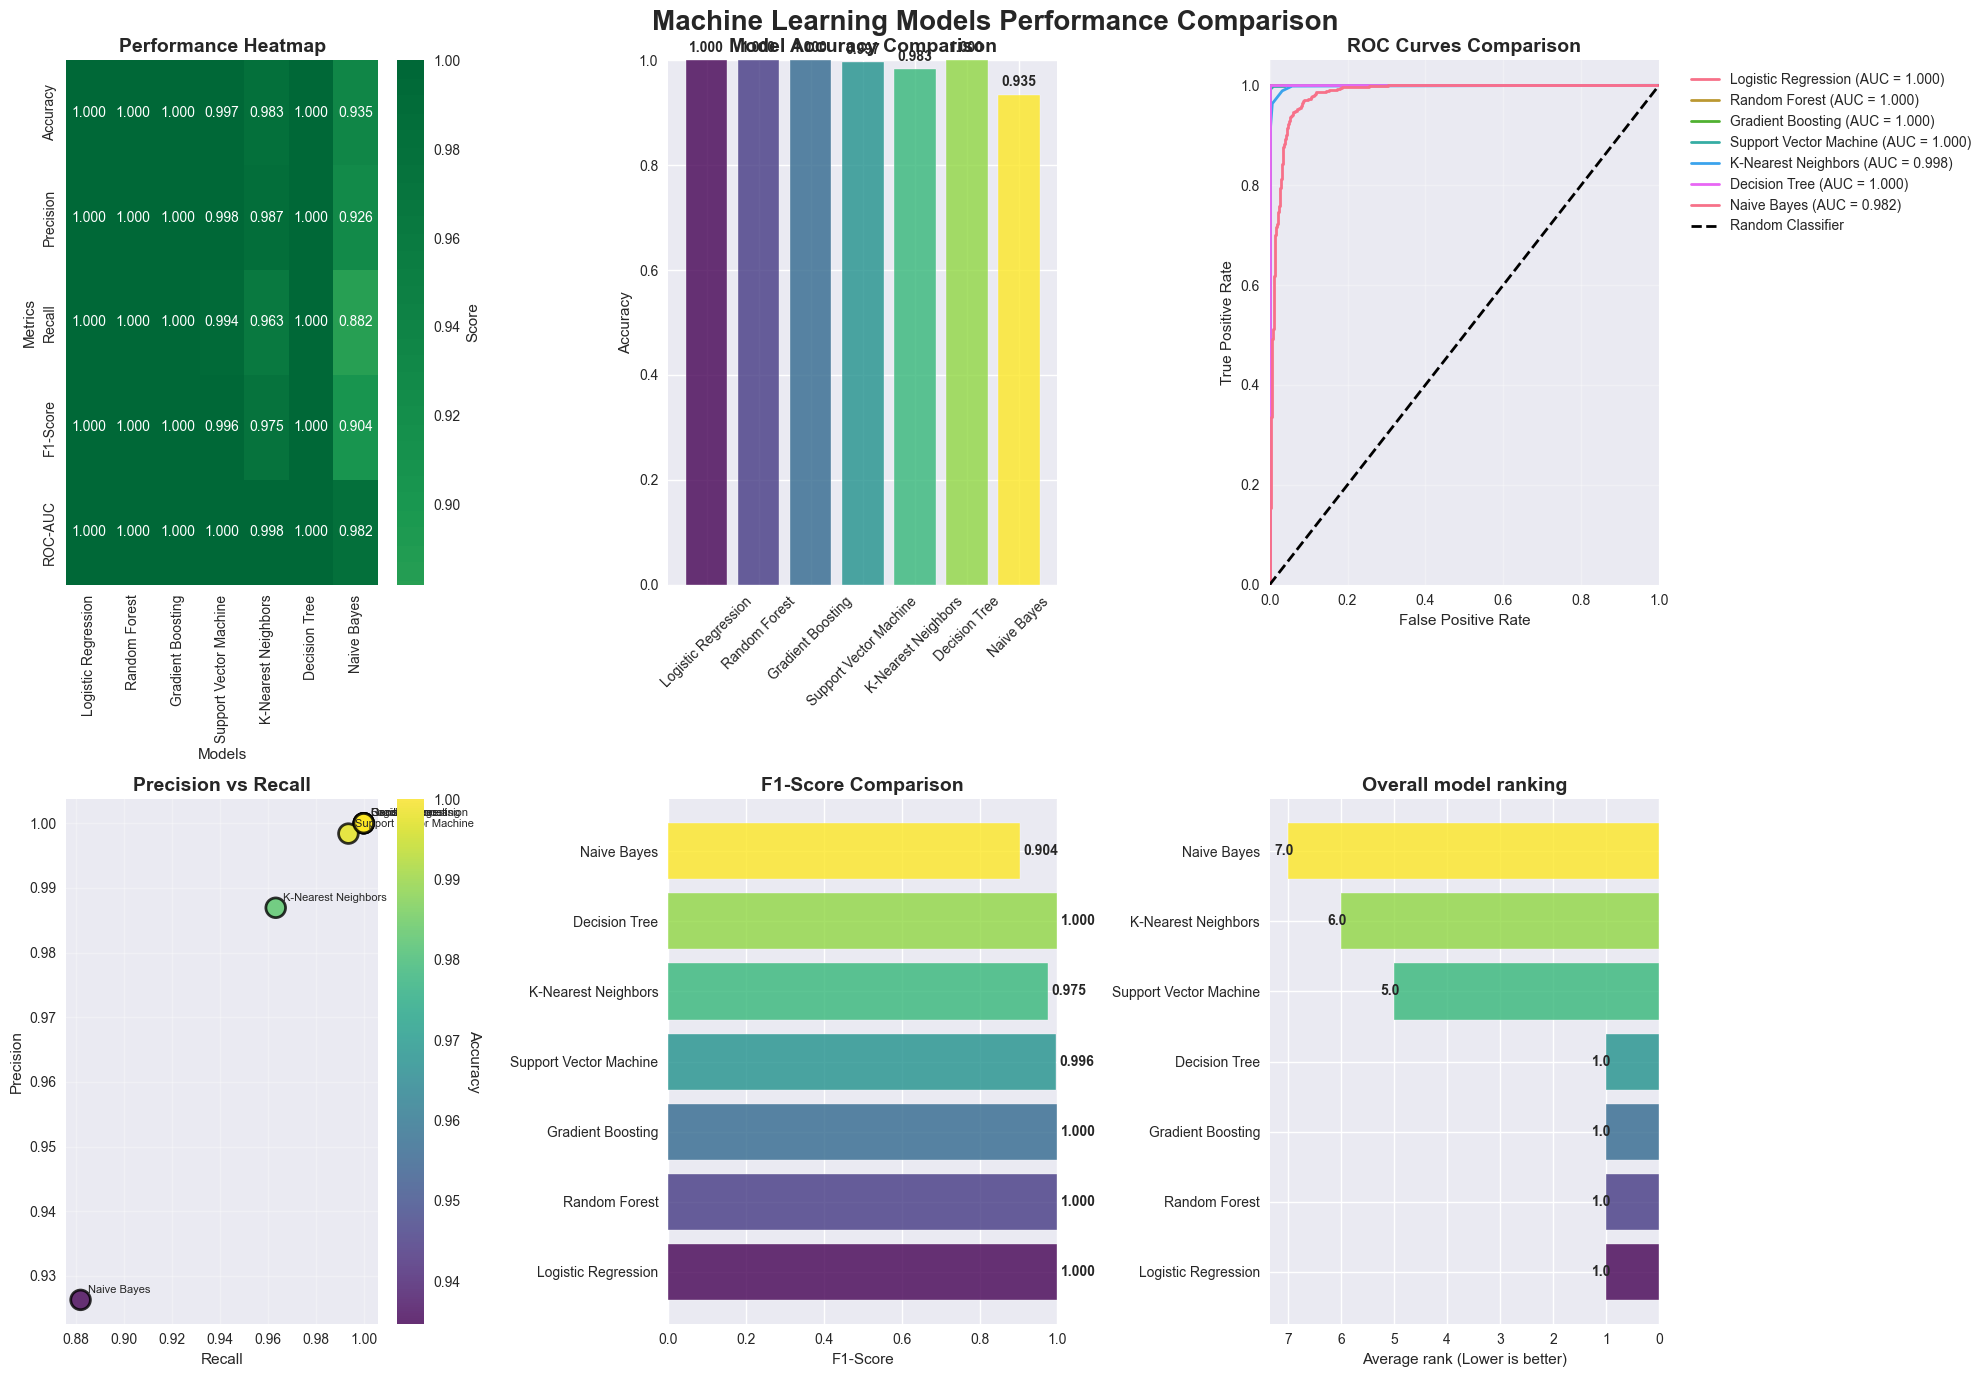

In [27]:
# Create comprehensive model comparison visualization
print("[#] MODEL PERFORMANCE COMPARISON")
print("=" * 45)

# Prepare data for visualization - extract only numeric metrics
metrics_data = {}
for model_name, model_results in results.items():
    metrics_data[model_name] = {
        'Accuracy': model_results['Accuracy'],
        'Precision': model_results['Precision'],
        'Recall': model_results['Recall'],
        'F1-Score': model_results['F1-Score'],
        'ROC-AUC': model_results['ROC-AUC']
    }

metrics_df = pd.DataFrame(metrics_data).T

# Display results table
print("Performance metrics summary:")
print(metrics_df.round(4))

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Machine Learning Models Performance Comparison', fontsize=20, fontweight='bold')

# Overall Performance Heatmap
sns.heatmap(metrics_df.T, annot=True, cmap='RdYlGn', center=0.5,
            fmt='.3f', ax=axes[0, 0], cbar_kws={'label': 'Score'})
axes[0, 0].set_title('Performance Heatmap', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Metrics')

# Accuracy Comparison
models_names = list(results.keys())
accuracies = [results[model]['Accuracy'] for model in models_names]
colors = plt.cm.viridis(np.linspace(0, 1, len(models_names)))

bars = axes[0, 1].bar(models_names, accuracies, color=colors, alpha=0.8)
axes[0, 1].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# ROC Curves Comparison
for model_name in models_names:
    fpr = results[model_name]['fpr']
    tpr = results[model_name]['tpr']
    roc_auc = results[model_name]['ROC-AUC']
    axes[0, 2].plot(fpr, tpr, linewidth=2,
                   label=f'{model_name} (AUC = {roc_auc:.3f})')

axes[0, 2].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
axes[0, 2].set_xlim([0.0, 1.0])
axes[0, 2].set_ylim([0.0, 1.05])
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 2].grid(True, alpha=0.3)

# Precision vs Recall
precisions = [results[model]['Precision'] for model in models_names]
recalls = [results[model]['Recall'] for model in models_names]

scatter = axes[1, 0].scatter(recalls, precisions, c=accuracies, s=200,
                           cmap='viridis', alpha=0.8, edgecolors='black', linewidth=2)
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Add model labels
for i, model in enumerate(models_names):
    axes[1, 0].annotate(model, (recalls[i], precisions[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('Accuracy', rotation=270, labelpad=15)

# F1-Score Comparison
f1_scores = [results[model]['F1-Score'] for model in models_names]
bars = axes[1, 1].barh(models_names, f1_scores, color=colors, alpha=0.8)
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xlim(0, 1)

# Add value labels
for bar, f1 in zip(bars, f1_scores):
    width = bar.get_width()
    axes[1, 1].text(width + 0.01, bar.get_y() + bar.get_height()/2.,
                   f'{f1:.3f}', ha='left', va='center', fontweight='bold')

# Model Ranking
ranking_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
model_ranks = {}

for model in models_names:
    ranks = []
    for metric in ranking_metrics:
        metric_values = [results[m][metric] for m in models_names]
        rank = sorted(metric_values, reverse=True).index(results[model][metric]) + 1
        ranks.append(rank)
    model_ranks[model] = np.mean(ranks)

# Sort models by average rank
sorted_models = sorted(model_ranks.items(), key=lambda x: x[1])
model_names_sorted = [model for model, _ in sorted_models]
avg_ranks = [rank for _, rank in sorted_models]

bars = axes[1, 2].barh(model_names_sorted, avg_ranks, color=colors, alpha=0.8)
axes[1, 2].set_xlabel('Average rank (Lower is better)')
axes[1, 2].set_title('Overall model ranking', fontsize=14, fontweight='bold')
axes[1, 2].invert_xaxis()  # Lower rank is better

# Add value labels
for bar, rank in zip(bars, avg_ranks):
    width = bar.get_width()
    axes[1, 2].text(width - 0.1, bar.get_y() + bar.get_height()/2.,
                   f'{rank:.1f}', ha='right', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [28]:
# Identify best performing model
best_model_name = min(model_ranks.items(), key=lambda x: x[1])[0]
best_model = model_objects[best_model_name]

print(f"[#] BEST PERFORMING MODEL: {best_model_name}")
print("=" * 50)

# Detailed analysis of the best model
best_results = results[best_model_name]
print(f"[#] Performance Metrics:")
print(f" - Accuracy: {best_results['Accuracy']:.4f}")
print(f" - Precision: {best_results['Precision']:.4f}")
print(f" - Recall: {best_results['Recall']:.4f}")
print(f" - F1-Score: {best_results['F1-Score']:.4f}")
print(f" - ROC-AUC: {best_results['ROC-AUC']:.4f}")

[#] BEST PERFORMING MODEL: Logistic Regression
[#] Performance Metrics:
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - ROC-AUC: 1.0000
